In [3]:
import torch
import torch.nn as nn
from torchvision.models import ResNet34_Weights
from torchvision.models import resnet34
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize, Resize, CenterCrop
from torchvision.transforms import v2
from tqdm import tqdm
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [5]:
# function using model to extract feature + label tensors from dataset
def extract_features(model, loader, device):
    # set model to evaluation mode
    model.eval()
    
    features, labels = [], []
    
    # gradients not needed for inference
    with torch.no_grad():
        for image, label in tqdm(loader, desc="Extracting features"):
            # Forward pass through the model
            image = image.to(device)
            label = label.to(device)
            features_batch = model(image)
            # Flatten the features
            features_batch = features_batch.view(features_batch.size(0), -1)
            features.append(features_batch.cpu())
            labels.append(label)
    
    return torch.cat(features, dim=0), torch.cat(labels, dim=0)

# function to create model pretrained on ImageNet only
def ImageNetModel(device):
    model = resnet34(weights=ResNet34_Weights.DEFAULT)
    model = model.to(device)
    return model

# function to find and plot KL divergence for a range of perplexity values
def find_perplexity(features, min_perplexity, max_perplexity, step, num_components):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    # array of perplexity values to test
    perplexity = np.arange(min_perplexity, max_perplexity, step)

    divergence = []
    
    # find the KL divergence for each perplexity value
    for i in perplexity:
        model = TSNE(n_components=num_components, init="pca", perplexity=i)
        reduced = model.fit_transform(features_np)
        divergence.append(model.kl_divergence_)
    
    # plot divergence
    fig = px.line(x=perplexity, y=divergence, markers=True)
    fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
    fig.update_traces(line_color="red", line_width=1)
    fig.show()
    
# function to perform tsne on features extracted and visualize results
def perform_tsne(features, perplexity, labels, title):
    # Convert to NumPy array
    features_np = features.cpu().numpy()
    labels = labels.cpu()
    
    # perform tsne
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, random_state=42)
    features_tsne = tsne.fit_transform(features_np)

    # plot results
    fig, ax = plt.subplots()
    scatter = ax.scatter(x=features_tsne[:, 0], y=features_tsne[:, 1], c=labels, alpha=0.3)
    legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.add_artist(legend1)
    plt.title(title)
    plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# load custom model
model1 = resnet34(num_classes=3).to(device)
model1.load_state_dict(torch.load("./model.pth", map_location=device))

# load ImageNet model
model2 = ImageNetModel(device)

models = {
    # remove final classification layer in each model
    "Custom Model": nn.Sequential(*list(model1.children())[:-1]),
    "ImageNet Model": nn.Sequential(*list(model2.children())[:-1])
}

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\sergi/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100.0%


In [9]:
# define transformations according to ImageNet preprocessing
ImageNet_transform = v2.Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define transformations according to custom model's preprocessing
custom_transform = v2.Compose([
    ToTensor(), 
    Normalize([0.7621, 0.5239, 0.7111], [0.0066, 0.0096, 0.0063])
])

# load transformed Dataset 2 and 3 for each model
data_loaders = {
    "Custom Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='./Prostate Cancer', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='./Animal Faces', transform=custom_transform), batch_size=64, shuffle=False, num_workers=4)
    },
    "ImageNet Model": {
        "Prostate Cancer": DataLoader(ImageFolder(root='./Prostate Cancer', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4),
        "Animal Faces": DataLoader(ImageFolder(root='./Animal Faces', transform=ImageNet_transform), batch_size=64, shuffle=False, num_workers=4)
    },
}

Extracting features: 100%|██████████| 94/94 [00:25<00:00,  3.69it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.002s...
[t-SNE] Computed neighbors for 6000 samples in 0.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 0.720304
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.761551
[t-SNE] KL divergence after 1000 iterations: 1.411607


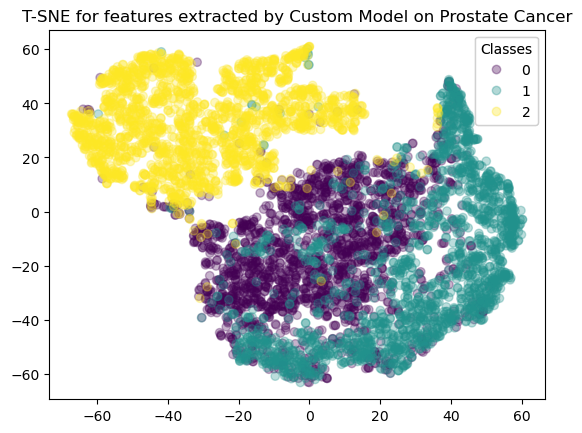

Extracting features: 100%|██████████| 94/94 [00:49<00:00,  1.89it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.003s...
[t-SNE] Computed neighbors for 6000 samples in 0.533s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 4.137119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.773895
[t-SNE] KL divergence after 1000 iterations: 1.339416


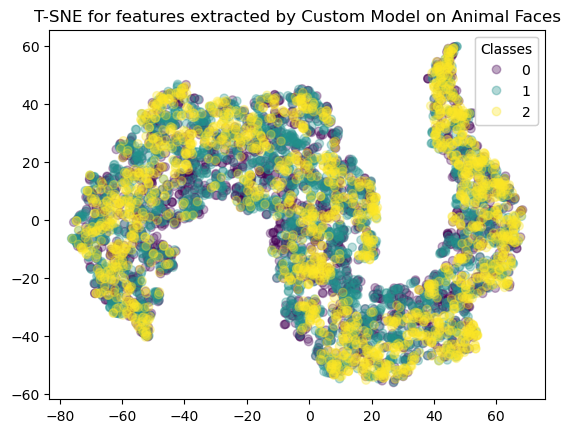

Extracting features: 100%|██████████| 94/94 [00:21<00:00,  4.32it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.002s...
[t-SNE] Computed neighbors for 6000 samples in 0.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 3.797173
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.673805
[t-SNE] KL divergence after 1000 iterations: 2.219532


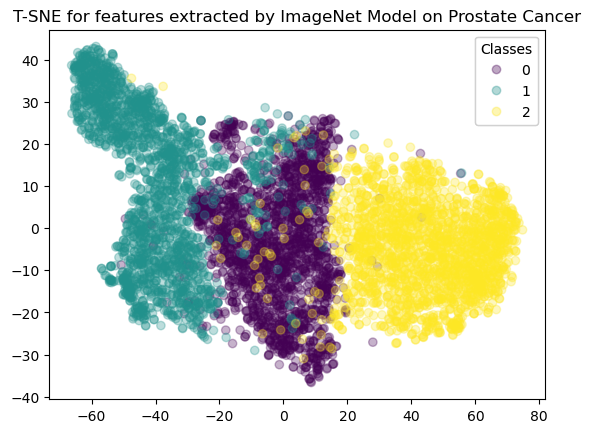

Extracting features: 100%|██████████| 94/94 [00:22<00:00,  4.20it/s]


[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.001s...
[t-SNE] Computed neighbors for 6000 samples in 0.388s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 3.770314
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.566917
[t-SNE] KL divergence after 1000 iterations: 1.380354


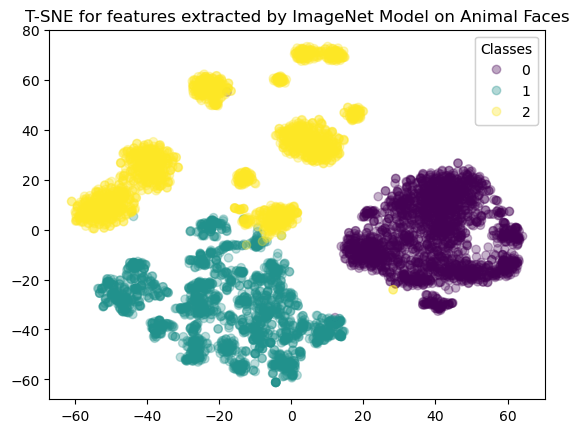

In [11]:
# apply feature extraction then tsne for 4 scenarios
# custom model on Dataset 2, custom model on Dataset 3
# ImageNet model on Dataset 2, ImageNet model on Dataset 3
extracted_features = {}
for model_name, model in models.items():
    for dataset_name, dataloader in data_loaders[model_name].items():
        features, labels = extract_features(model, dataloader, device)
        key = model_name + "_" + dataset_name
        extracted_features[key] = {
            "features" : features,
            "labels" : labels
        }
        perform_tsne(features, 35, labels, f"T-SNE for features extracted by {model_name} on {dataset_name}")

In [30]:
X = extracted_features["Custom Model_Prostate Cancer"]["features"].detach().cpu().numpy()
y = extracted_features["Custom Model_Prostate Cancer"]["labels"].detach().cpu().numpy()
Cancer_Classes = ["Gland", "NonGland", "Tumour"]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109)


In [18]:

clf = svm.NuSVC(gamma='auto')
clf.fit(X_train, y_train)



NuSVC(gamma='auto')

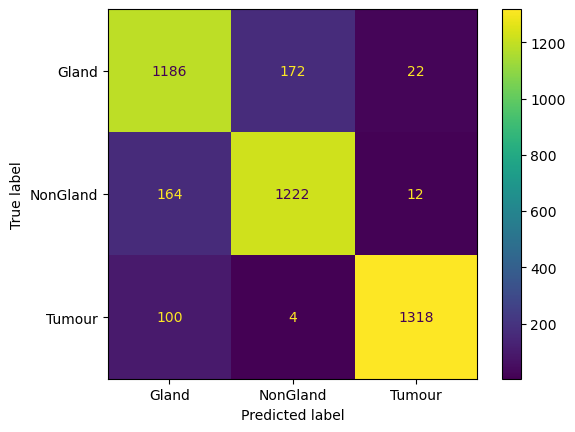

In [31]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
y_pred_train =  clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Cancer_Classes)
disp.plot()

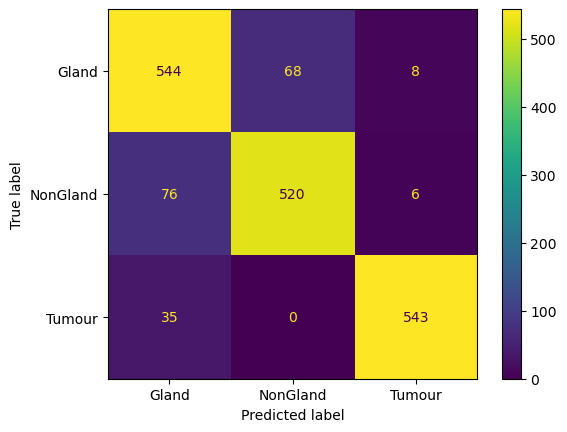

In [32]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
y_pred_test =  clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Cancer_Classes)
disp.plot()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=Cancer_Classes))

              precision    recall  f1-score   support

       Gland       0.82      0.86      0.84      1380
    NonGland       0.87      0.87      0.87      1398
      Tumour       0.97      0.93      0.95      1422

    accuracy                           0.89      4200
   macro avg       0.89      0.89      0.89      4200
weighted avg       0.89      0.89      0.89      4200



In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test, target_names=Cancer_Classes))

              precision    recall  f1-score   support

       Gland       0.83      0.88      0.85       620
    NonGland       0.88      0.86      0.87       602
      Tumour       0.97      0.94      0.96       578

    accuracy                           0.89      1800
   macro avg       0.90      0.89      0.89      1800
weighted avg       0.89      0.89      0.89      1800

